/Users/blakeweiss/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model path: /Users/blakeweiss/Desktop/Predict_Pancreatic_Cancer/pancreatic_cancer_RF_HGB_LR_predictor.pkl
Script folder: /Users/blakeweiss/Desktop/Predict_Pancreatic_Cancer

Data source imported: /Users/blakeweiss/.cache/kagglehub/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer/versions/1
  sample_id patient_cohort sample_origin  age sex  diagnosis stage  \
0        S1        Cohort1          BPTB   33   F          1   NaN   
1       S10        Cohort1          BPTB   81   F          1   NaN   
2      S100        Cohort2          BPTB   51   M          1   NaN   
3      S101        Cohort2          BPTB   61   M          1   NaN   
4      S102        Cohort2          BPTB   62   M          1   NaN   
5      S103        Cohort2          BPTB   53   M          1   NaN   
6      S104        Cohort2          BPTB   70   M          1   NaN   
7      S105        Cohort2          BPTB   58   F          1   NaN   
8      S106        Cohort2          BPTB   59   F          1   Na

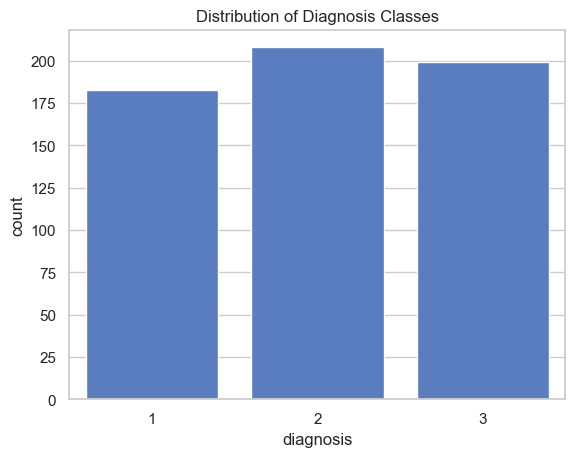

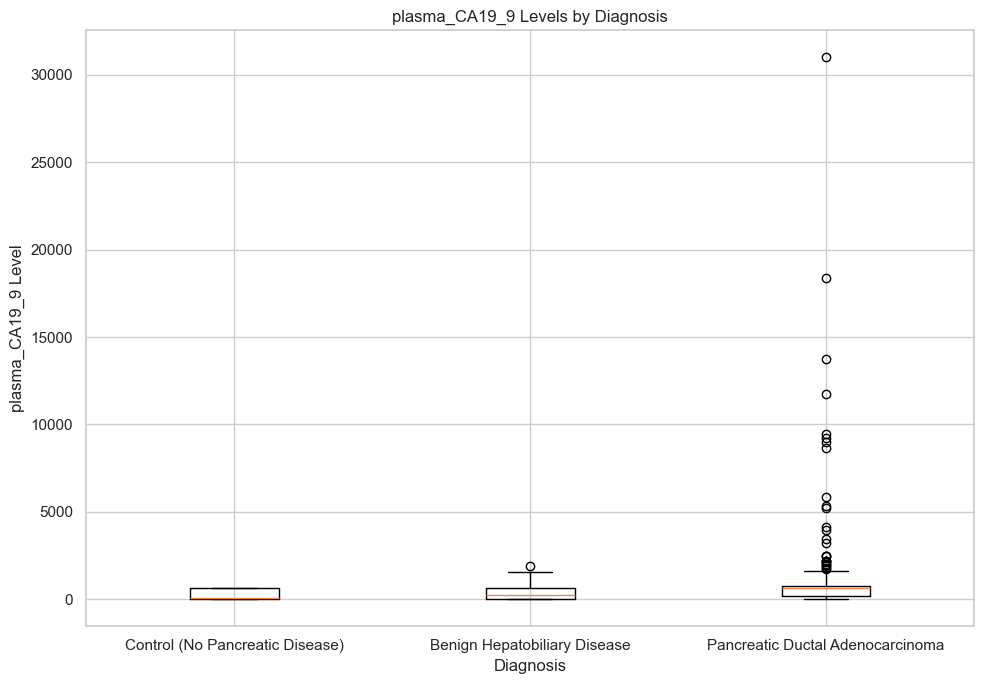

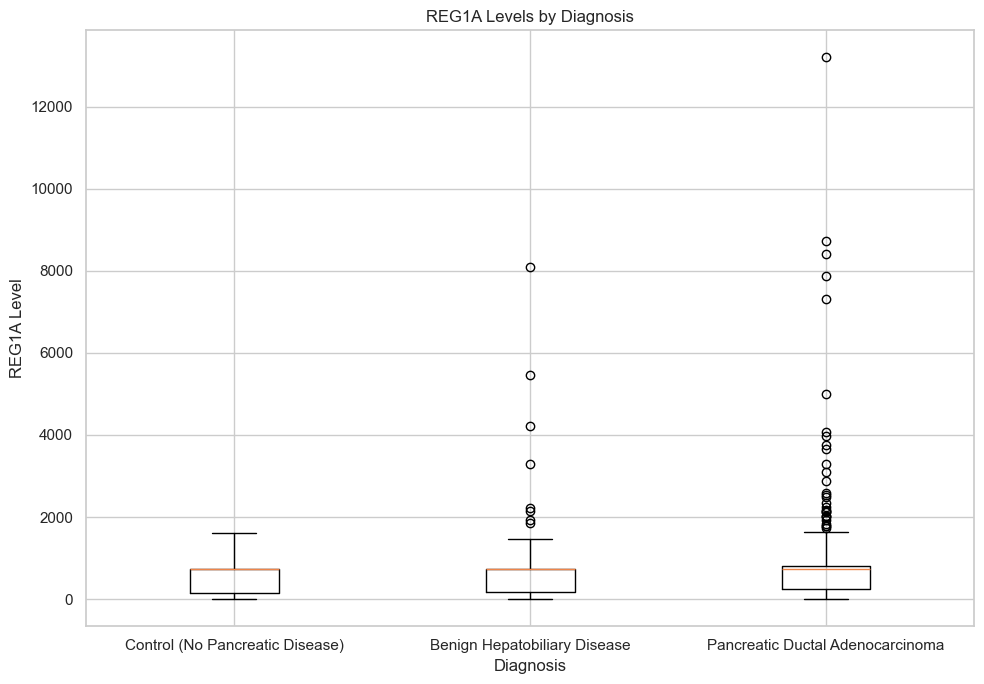

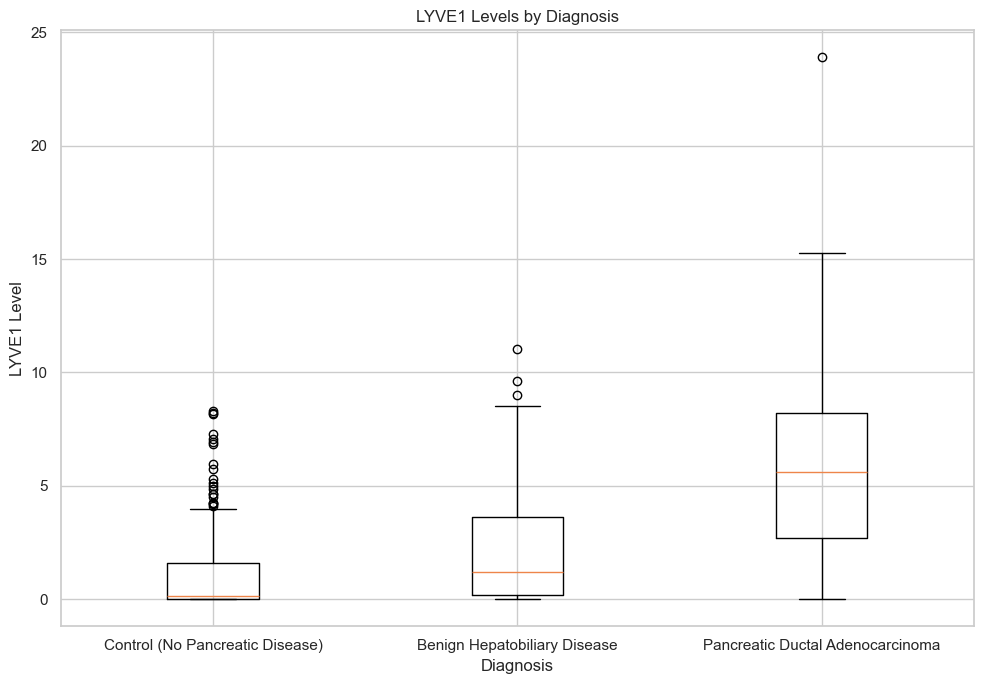

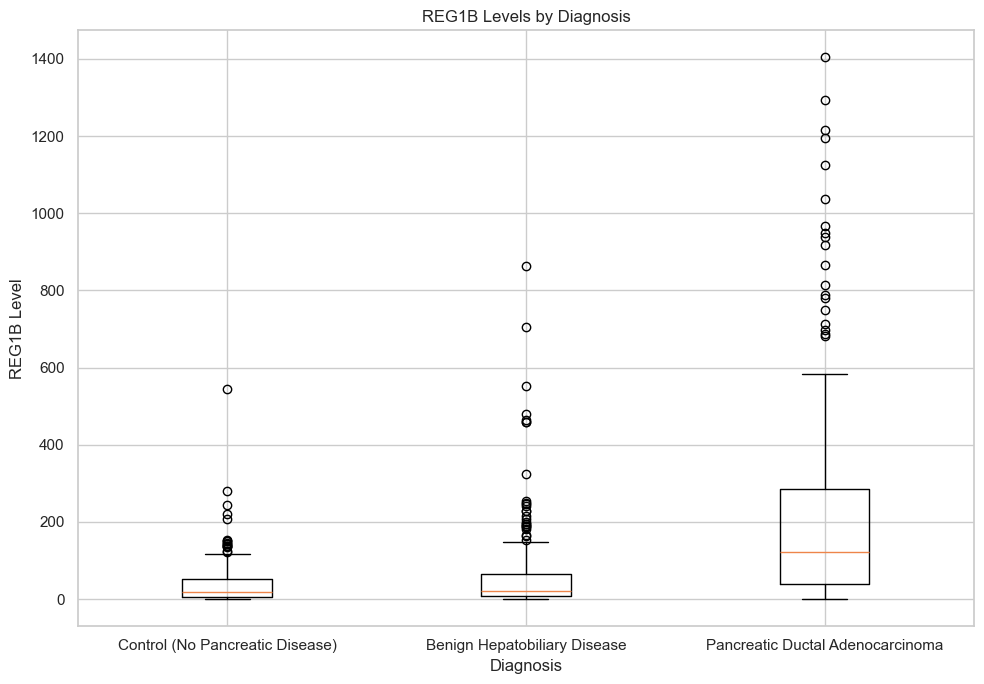

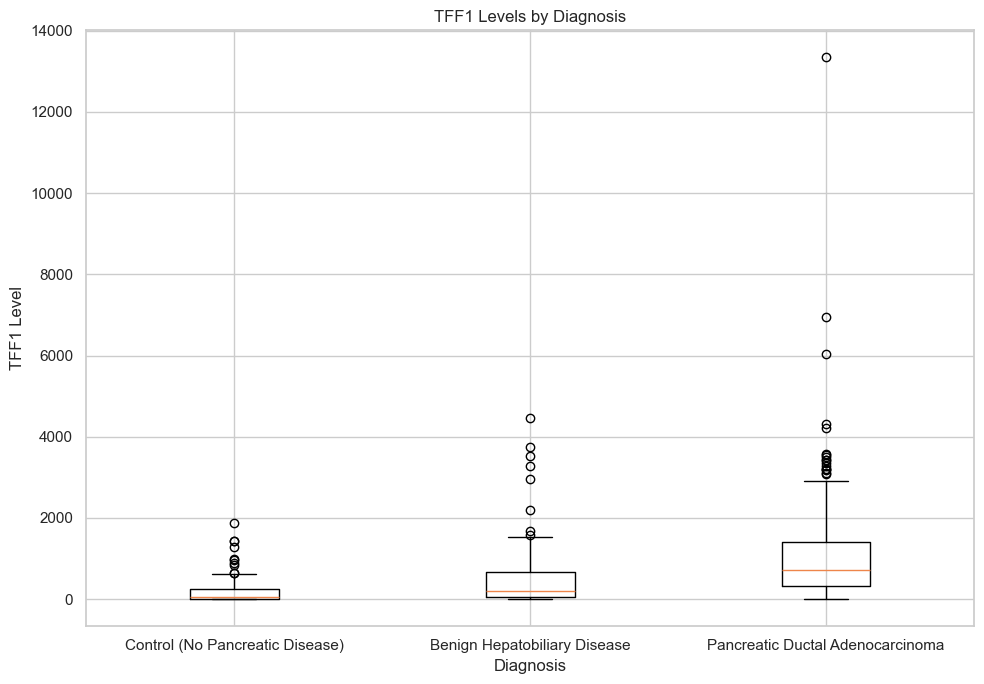

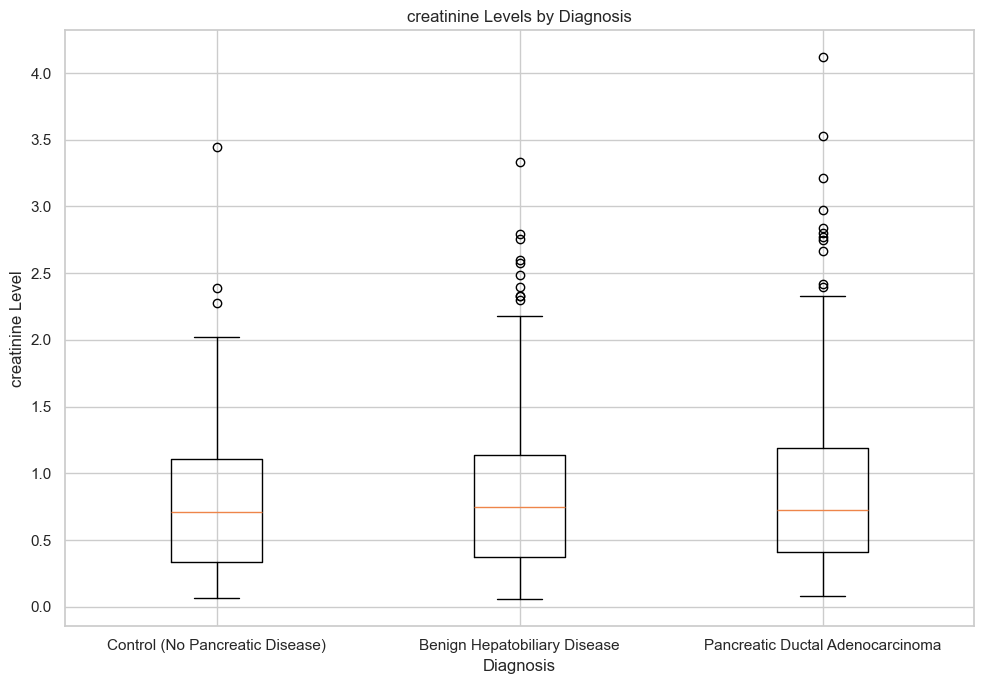

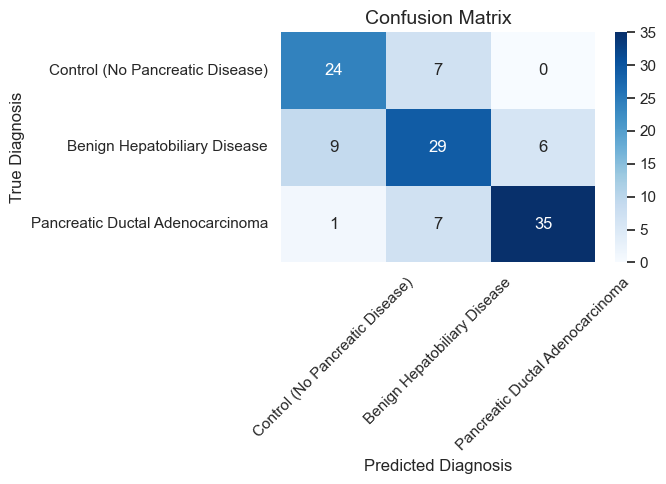


Computing permutation importances
         feature  importance
4          LYVE1    0.108475
2  plasma_CA19_9    0.104237
6           TFF1    0.096610
0            age    0.055932
7          REG1A    0.052542
3     creatinine    0.041525
5          REG1B    0.005085
1            sex    0.002542


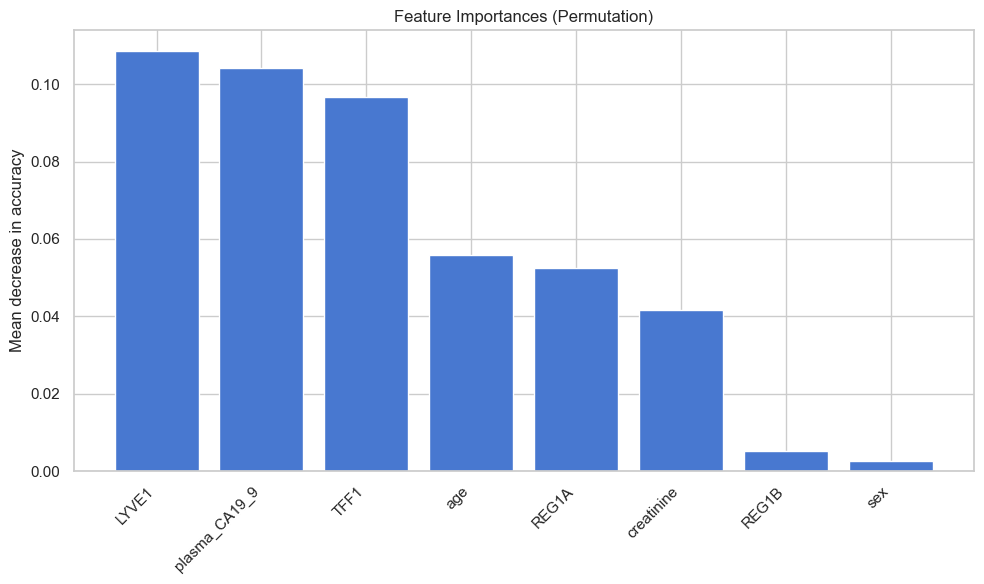


ANOVA for plasma_CA19_9: F = 17.40, p = 4.57e-08


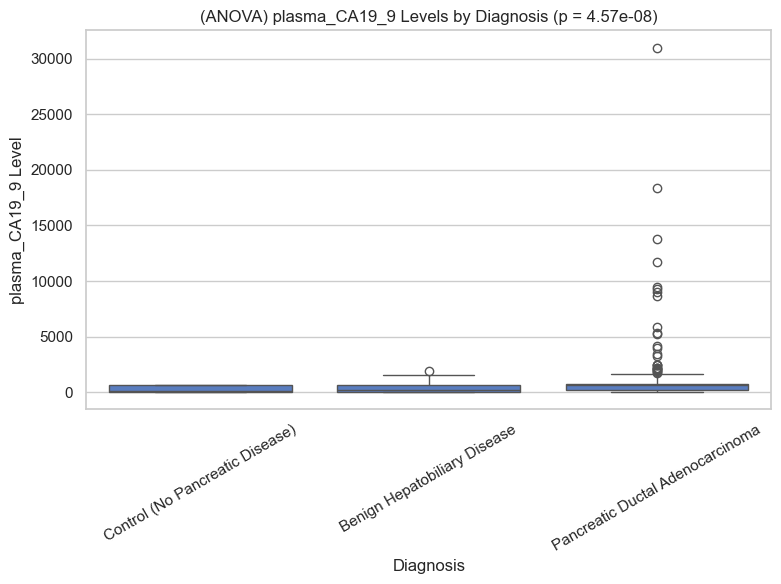


ANOVA for REG1A: F = 11.96, p = 8.096e-06


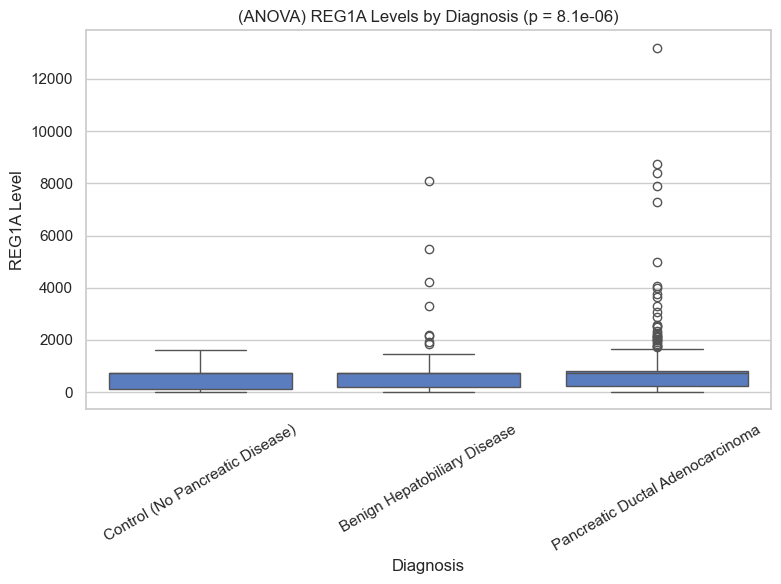


ANOVA for LYVE1: F = 145.06, p = 6.417e-52


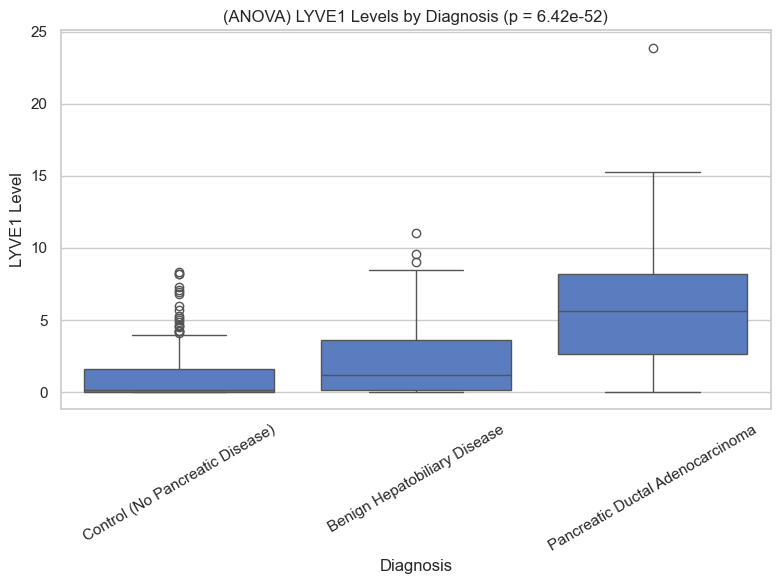


ANOVA for REG1B: F = 62.63, p = 2.223e-25


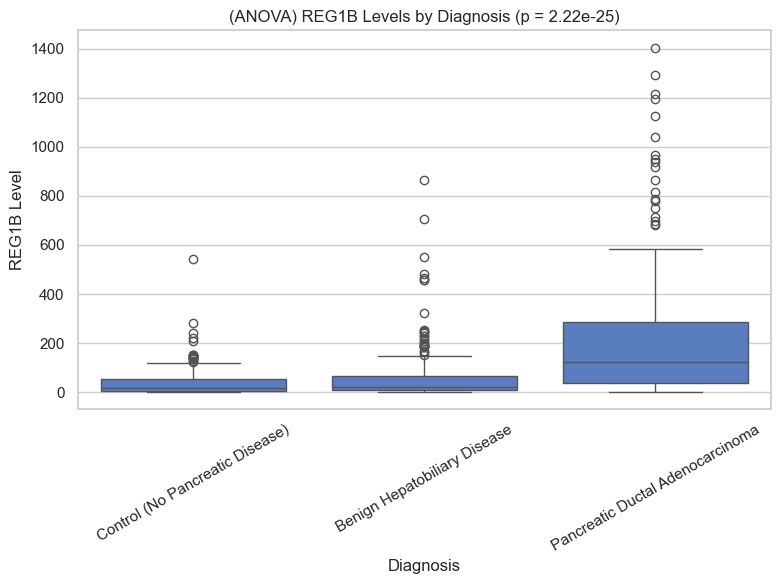


ANOVA for TFF1: F = 57.60, p = 1.436e-23


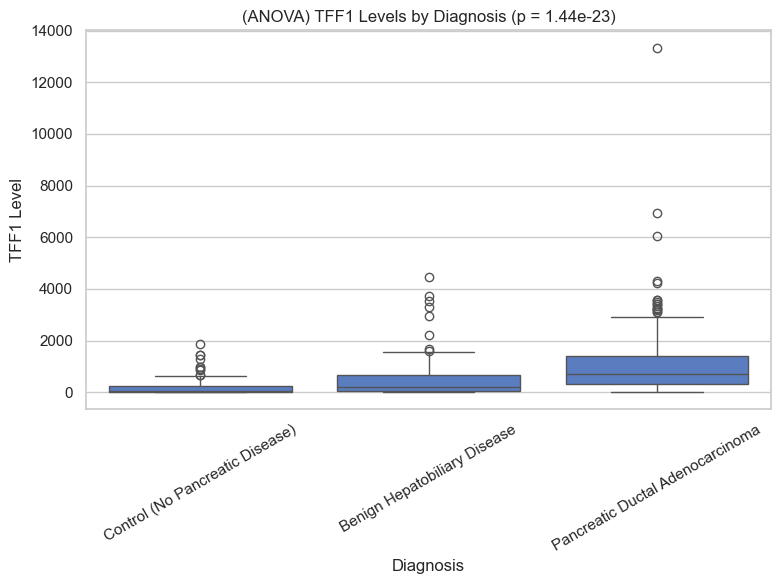


ANOVA for creatinine: F = 1.67, p = 0.1894


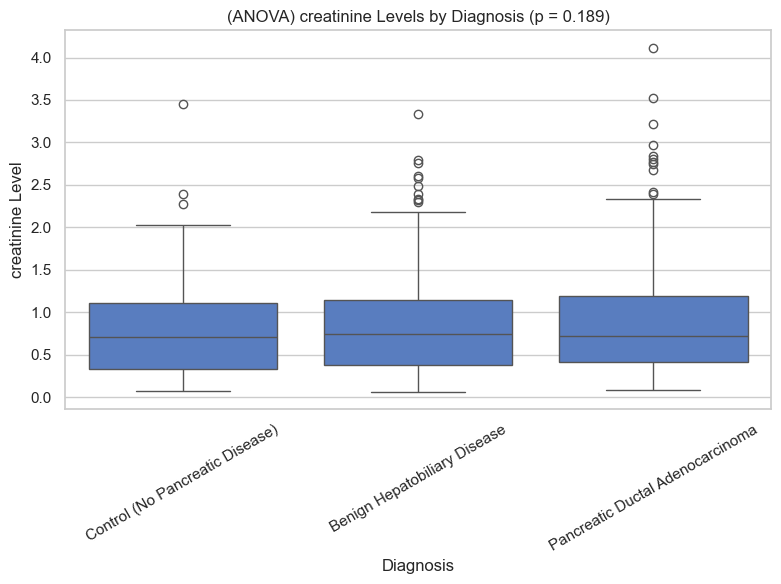


=========================Seperate Testing Section=========================
Randomly select patients from the test set to evaluate the model
The amount of randomly selected patients are: 37

Accuracy over the entire 20% test set (the gold standard performance metric).
Overall Accuracy on Test Set: 0.746


Randomly selected patients and their predicted diagnoses:
----------------------------------------------------------------------------------------------------------
Patient S318: | Predicted Diagnosis: Benign Hepatobiliary Disease | True Diagnosis: Benign Hepatobiliary Disease | True
Patient S501: | Predicted Diagnosis: Pancreatic Ductal Adenocarcinoma | True Diagnosis: Pancreatic Ductal Adenocarcinoma | True
Patient S53: | Predicted Diagnosis: Control (No Pancreatic Disease) | True Diagnosis: Control (No Pancreatic Disease) | True
Patient S13: | Predicted Diagnosis: Control (No Pancreatic Disease) | True Diagnosis: Control (No Pancreatic Disease) | True
Patient S366: | Predicted Diag

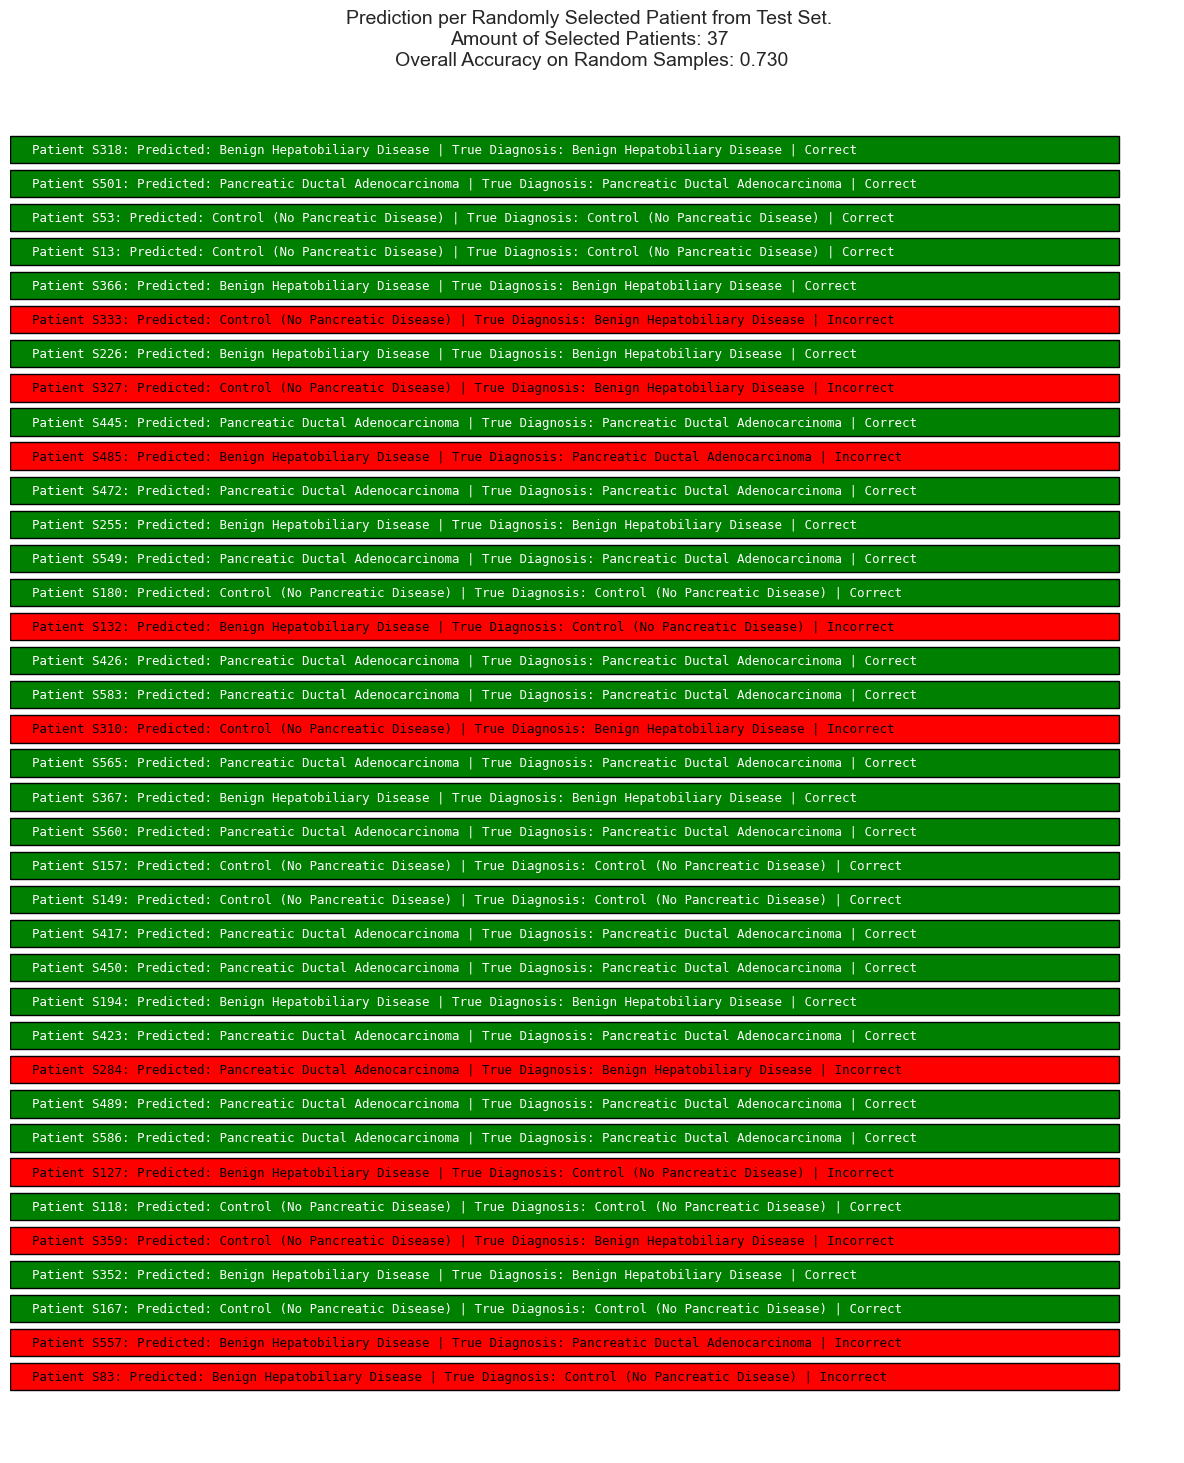

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Pancreatic Cancer Predictive Model
This program trains a model to predict pancreatic cancer using urinary biomarkers.
The dataset is from the study "Urinary Biomarkers for Pancreatic Cancer" by Debernardi et al. (2020).

The diagnosis classes are defined as:
    1: Control (No Pancreatic Disease)
    2: Benign Hepatobiliary Disease (including chronic pancreatitis)
    3: Pancreatic Ductal Adenocarcinoma (Pancreatic Cancer)
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
from warnings import filterwarnings
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import random
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

#Global Settings
SCRIPT_DIR = Path.cwd() # if using jupyter notebook, use this line
#SCRIPT_DIR = Path(__file__).parent  # Directory of this script. if using reg .py use this line

MODEL_FILENAME = 'pancreatic_cancer_RF_HGB_LR_predictor.pkl'
MODEL_PATH = SCRIPT_DIR / MODEL_FILENAME
print("Model path:", MODEL_PATH)
print("Script folder:", SCRIPT_DIR)

#class labels for readability.
CLASS_LABELS = {
    1: "Control (No Pancreatic Disease)",
    2: "Benign Hepatobiliary Disease",
    3: "Pancreatic Ductal Adenocarcinoma"
}

#suppress warnings
filterwarnings('ignore')


#Data Loading and Preprocessing
def load_and_preprocess_data():
    """
    Downloads (if necessary) and loads the dataset cleans and preprocesses it
    
    Returns:
        df (DataFrame): The preprocessed dataset with sample_id set as identifyer
    """
    #download dataset using Kaggle.
    data_source = kagglehub.dataset_download("johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer")
    print('\nData source imported:', data_source)
    
    #set the path to the downloaded dataset.
    data_dir = Path('/Users/blakeweiss/.cache/kagglehub/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer/versions/1')
    data_file = data_dir / 'Debernardi et al 2020 data.csv'
    
    if not data_file.exists():
        raise FileNotFoundError(f"Data file not found: {data_file}\nPlease check the path and ensure the dataset is correctly downloaded.")
    
    #read CSV data into a DataFrame
    df = pd.read_csv(data_file)
    
    #print basic information.
    print(df.head(10))
    print("Data shape:", df.shape)
    print("\nMissing values per column:\n", df.isna().sum())
    
    #preserve 'sample_id' by setting it as the index/identifer
    #drop other columns that are not useful (ex, stage, benign_sample_diagnosis, sample_origin)
    #and drop 'patient_cohort' since the cohort doesnt matter
    df.set_index('sample_id', inplace=True)
    #data values that are not being passed and are being dropped due to many reasons
    df.drop(['stage', 'sample_origin', 'benign_sample_diagnosis', 'patient_cohort'], axis=1, inplace=True) 
    

    #mean imputation: fill missing values in key data biomarkers using the actual mean of said data markers
    #this is meant to preserve accuracy of the model. and input missing values with means of said values 
    #print("Using mean imputation for missing values") #debugging line
    df['plasma_CA19_9'].fillna(df['plasma_CA19_9'].mean(), inplace=True)
    df['REG1A'].fillna(df['REG1A'].mean(), inplace=True)

    print("\nMissing values after cleaning:\n", df.isna().sum())
    
    #convert categorical text to numeric.
    df['sex'] = df['sex'].map({'M': 1, 'F': 0})
    #df['sample_origin'] = df['sample_origin'].map({'BPTB': 0, 'LIV': 1, 'ESP': 2, 'UCL': 3}) 
    #this line above mapped sample_origin to numbers corrsponding to orgins but was not used in the model.
    #commented above line out because to do something simlar to feature importance visualizations had to drop sample_origin from dataset.
    
    return df


#model training and evaluation and hyperparameter tuning
def train_tuned_model(X_train, y_train, X_test, y_test):
    """Grid‐search to prune the tree and return the best pipeline."""
    
    #build the base pipeline
    stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=0)),
        ('hgb', HistGradientBoostingClassifier(random_state=0))
        ],
        final_estimator=LogisticRegression(),
        cv=5
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', stack)           #note: called "classifier"
    ])

    #param_grid keys can start with "classifier__"
    param_grid = {
        #tune the final logistic-regression C
        #'classifier__final_estimator__C': [0.01, 0.1, 1, 10], #old line/original line
        'classifier__final_estimator__C': [0.01, 0.1, 1, 10, 100, 150, 200, 250],
        #, 300 no 150 or 250
        
        #tune how many trees in your RF base learner
        #'classifier__rf__n_estimators': [50, 100, 200], #old line/original line
        'classifier__rf__n_estimators': [50, 100, 200, 300, 400],
        #, 500
        
        #tune how many boosting iterations in HistGB
        #'classifier__hgb__max_iter': [50, 100, 200], #old line/original line
        'classifier__hgb__max_iter': [50, 100, 150, 200, 250, 300],
        #no 150 or 250
    }

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1, 
        verbose=1
    )
    
    
    #RandomizedSearchCV for faster tuning randomized hyperparmeter tuning 
    # param_dist = {
    #     'classifier__max_depth':           [None, 5, 10, 15, 20, 25],
    #     'classifier__min_samples_split':   [2, 5, 10, 20, 50, 100],
    #     'classifier__min_samples_leaf':    [1, 2, 5, 10, 20, 50]
    # }
    
    # grid = RandomizedSearchCV(
    #     estimator=base_pipe,
    #     param_distributions=param_dist,
    #     n_iter=50,           # sample 50 random combos
    #     cv=5,
    #     scoring='accuracy',
    #     n_jobs=-1,
    #     random_state=42,
    #     verbose=1
    # )
    
    
    #fit the grid search
    grid.fit(X_train, y_train)

    #Report best parameters and CV score
    print("Best hyperparameters:", grid.best_params_)
    
    #this is performance on the training data (evaluated via CV folds)
    #not the final evaluation on your separate unseen X_test which is reported by best_pipe.score(X_test, y_test)
    print(f"\nBest CV accuracy: {grid.best_score_:.3f}")

    #Evaluate on the test set
    best_pipe = grid.best_estimator_
    test_acc = best_pipe.score(X_test, y_test)
    print(f"Test accuracy (tuned): {test_acc:.3f}")

    #detailed classification report
    y_pred = best_pipe.predict(X_test)
    print("\nClassification Report (tuned):")
    print(classification_report(y_test, y_pred))

    return best_pipe


#Visualization Functions - should all work but cation is advised because had to just learn how to plot this stuff
def visualize_results(df, X, y, y_test, y_pred, pipeline):
    """Generates refined plots for data exploration and model evaluation"""
    
    #set a consistent overall seaborn style.
    sns.set(style="whitegrid", palette="muted")
    
    
    #Visualize the distribution of the diagnous variable classes
    #print check class distribution
    print(df['diagnosis'].value_counts()) #debugging line
    #visualize it
    sns.countplot(x='diagnosis', data=df)
    plt.title('Distribution of Diagnosis Classes')
    plt.show()

    
    #=========================================================================================================
    #BOX PLOTS OF BIOMARKERS BY DIAGNOSIS
    #=========================================================================================================

    #Box Plot for plasma_CA19_9 by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['plasma_CA19_9'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('plasma_CA19_9 Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('plasma_CA19_9 Level')
    plt.tight_layout()
    plt.show()
    
    
    #Box Plot for REG1A by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['REG1A'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('REG1A Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('REG1A Level')
    plt.tight_layout()
    plt.show()
    
    
    #Box plot for LYVE1 by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['LYVE1'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('LYVE1 Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('LYVE1 Level')
    plt.tight_layout()
    plt.show()
    
    
    #Box plot for REG1B by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['REG1B'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('REG1B Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('REG1B Level')
    plt.tight_layout()
    plt.show()
    
    
    #Box plot for TFF1 by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['TFF1'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('TFF1 Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('TFF1 Level')
    plt.tight_layout()
    plt.show()
    
    
    #Box plot for creatinine by diagnosis
    plt.figure(figsize=(10, 7))
    data_to_plot = [df[df['diagnosis'] == label]['creatinine'] 
                    for label in sorted(df['diagnosis'].unique())]
    plt.boxplot(data_to_plot, labels=[CLASS_LABELS.get(label, label) 
                                      for label in sorted(df['diagnosis'].unique())])
    plt.title('creatinine Levels by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel('creatinine Level')
    plt.tight_layout()
    plt.show()
    
    #=========================================================================================================
    
    #Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                      xticklabels=[CLASS_LABELS.get(cls, str(cls)) for cls in sorted(y.unique())],
                      yticklabels=[CLASS_LABELS.get(cls, str(cls)) for cls in sorted(y.unique())])
    plt.xlabel("Predicted Diagnosis", fontsize=12)
    plt.ylabel("True Diagnosis", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

    #Feature Importance using Permutation Importance - shows the importance of each feature/datapoint in the model
    print("\nComputing permutation importances")
    X_test = X.loc[y_test.index]
    perm = permutation_importance(
        pipeline,
        X_test,
        y_test,
        n_repeats=10,
        random_state=0,
        n_jobs=-1
    )
    fi = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm.importances_mean
    }).sort_values('importance', ascending=False)
    
    #plot permutation importances
    print(fi)
    plt.figure(figsize=(10, 6))
    plt.bar(fi['feature'], fi['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Mean decrease in accuracy")
    plt.title("Feature Importances (Permutation)")
    plt.tight_layout()
    plt.show()


    
#Model Persistence and Inference
def save_model(pipeline):
    """Saves the trained model pipeline to disk."""
    joblib.dump(pipeline, MODEL_PATH)
    print(f'\nModel saved as {MODEL_PATH}')


#this function is not utlized currently anywhere 
#because i didnt seperate the main function and test random patients parts of the main function
def predict_cancer(input_data): 
    """
    Diagnose pancreatic cancer from input data
    Parameters:
        input_data (dict or pd.DataFrame): Data for one patient. The keys must match the training features.
        
    Returns:
        prediction (int): Predicted diagnosis.
    """
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()

    #load the saved model.
    model = joblib.load(MODEL_PATH)
    prediction = model.predict(input_df)
    #print("prediction:", prediction) #debugging line
    return prediction[0]


def main():
    df = load_and_preprocess_data()
    
    #define features and target.
    target = 'diagnosis'
    X = df.drop(target, axis=1)  #sample_id is now the identifyer and is not used as a feature.
    y = df[target]
    
    #train and evaluate the model also split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #hyperparameter tuning + training
    pipeline = train_tuned_model(X_train, y_train, X_test, y_test)

    #get predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    #save the trained model.
    save_model(pipeline)
    
    #run visualizations and statistical tests.
    visualize_results(df, X, y, y_test, y_pred, pipeline)
    

    #ANOVA TESTS AND BOX PLOTS - ANOVA tells you if a biomarker’s mean value differs significantly across diagnosis groups (Control, Benign, Cancer).
    biomarkers = ['plasma_CA19_9', 'REG1A', 'LYVE1', 'REG1B', 'TFF1', 'creatinine']

    for biomarker in biomarkers:
        #ANOVA tests
        groups = [group[biomarker].dropna().values for _, group in df.groupby('diagnosis')]
        f_stat, p_val = f_oneway(*groups)
        print(f"\nANOVA for {biomarker}: F = {f_stat:.2f}, p = {p_val:.4g}")
        
        #Boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='diagnosis', y=biomarker, data=df)
        plt.title(f'(ANOVA) {biomarker} Levels by Diagnosis (p = {p_val:.3g})')
        plt.xlabel("Diagnosis")
        plt.ylabel(f"{biomarker} Level")
        plt.xticks([0, 1, 2], [CLASS_LABELS[i+1] for i in range(3)], rotation=30)
        plt.tight_layout()
        plt.show()
        
   
    
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

    
    print("\n=========================Seperate Testing Section=========================")
    print("Randomly select patients from the test set to evaluate the model")
    
    # Combine X_test and y_test into a DataFrame to sample from test set only
    test_df = X_test.copy()
    test_df['diagnosis'] = y_test
    #print("Test set shape:", test_df.shape)
    #print("Test set head:\n", test_df.head())
    
    #randomly select number of test patients 
    numoftestpatients=random.randint(10, 60) #orignally set the last value to 75
    
    #old line to sample from the entire dataset (this causes issues use the test_df instead)
    #random_samples = df.sample(n=numoftestpatients, random_state=42) 
    
    #new line to sample from the test set only
    random_samples = test_df.sample(n=numoftestpatients, random_state=42) 

    print("The amount of randomly selected patients are:", numoftestpatients)
    true_diagnoses = random_samples['diagnosis'].tolist()
    sample_inputs = random_samples.drop('diagnosis', axis=1) #drop the diagnosis column for prediction
        
    #predict diagnoses for the random patients
    predictions = pipeline.predict(sample_inputs)
    
    
    #print overall accuracy of the model on the test set
    #accuracy over the entire 20% test set (the gold standard performance metric).
    print("\nAccuracy over the entire 20% test set (the gold standard performance metric).")
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy on Test Set: {overall_accuracy:.3f}")
    

    predicted_labels = [CLASS_LABELS.get(pred, pred) for pred in predictions]
    true_labels = [CLASS_LABELS.get(label, label) for label in true_diagnoses]
    
    #print the results for the randomly selected patients in terminal
    print("\n\nRandomly selected patients and their predicted diagnoses:")
    print("----------------------------------------------------------------------------------------------------------")
    for idx, true_label, predicted_label in zip(random_samples.index, true_labels, predicted_labels):
        if predicted_label == true_label:
            was_prediction_the_correct = True
        else:
            was_prediction_the_correct = False
        
        print(f"Patient {idx}: | Predicted Diagnosis: {predicted_label} | True Diagnosis: {true_label} | {was_prediction_the_correct}")
        
    
    
    #Accuracy over a random subset of the test set — a quick spot check.
    #this is not the same as the overall accuracy of the model on the test set.
    #this is a quick spot check to see if the model is working correctly.
    print("\n\nAccuracy over a random subset of the test set — a quick spot check.")
    accuracy = accuracy_score(true_diagnoses, predictions)
    print(f"Overall Accuracy on Random Samples: {accuracy:.3f}")
    
    
#=========================================================================================================
#======================PLOT THE PREDICTIONS FOR THE RANDOMLY SELECTED PATIENTS============================
#=========================================================================================================

    #prepare patient info
    predicted_labels = [CLASS_LABELS.get(pred, pred) for pred in predictions]
    true_labels = [CLASS_LABELS.get(label, label) for label in true_diagnoses]

    patient_ids = [f"Patient {idx}" for idx in random_samples.index]
    correctness = [pred == true for pred, true in zip(predicted_labels, true_labels)]
    colors = ["green" if correct else "red" for correct in correctness]

    #use constant bar length for display
    bar_lengths = [1] * len(patient_ids)
    y_pos = np.arange(len(patient_ids))

    #plot horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 0.4 * len(patient_ids)))

    ax.barh(y_pos, bar_lengths, color=colors, edgecolor='black')

    #add text labels with predicted and true diagnosis
    for i, (pid, pred, true, correct) in enumerate(zip(patient_ids, predicted_labels, true_labels, correctness)):
        status = "Correct" if correct else "Incorrect"
        label = f"Predicted: {pred} | True Diagnosis: {true} | {status}"
        ax.text(0.02, i, f"{pid}: {label}", va='center', fontsize=9, color='white' if correct else 'black', fontfamily='monospace')

    #format
    ax.set_yticks(y_pos)
    ax.set_yticklabels(patient_ids)
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.set_xlim(0, 1.05)
    ax.set_title(f"Prediction per Randomly Selected Patient from Test Set. \nAmount of Selected Patients: {numoftestpatients} \nOverall Accuracy on Random Samples: {accuracy:.3f}", fontsize=14)
    ax.axis('off')

    plt.savefig(SCRIPT_DIR / "patient_predictions.pdf", format="pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    
    
    
if __name__ == '__main__':
    main()